# Parameter sensitivity study - loop 02


Parameter sensitivity study - Loop 2 was performed for random board states available in library that have at least 25 free fields. n=100 repetitions for each set.

Parameter sets tested:

                    99.9%, 99%, 97%, 95%
conf_level_values = [3.29, 2.58, 2.17, 1.96]

margin_estim_values = [1.00]

margin_highest_values = [0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22, 0.24, 0.26, 0.28, 0.30]

# Load result files

Load the sensitivity study results file from loop 02

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import stats

pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1700)
pd.set_option('display.max_columns', 20)
pd.set_option('max_colwidth', 2000)

param_sens_study_dir = "param_sens_study\\L02"
param_sens_study_file = "param_sens_study_file.csv"
param_sens_study_path = os.path.join(param_sens_study_dir, param_sens_study_file)

df = pd.read_csv(param_sens_study_path)
print(df.dtypes)

# Remove incomplete data
df = df[df.board_state_100chars_code != '0000000000000000000077700000007470000000747700000074700700007470701100777700070072277777777777555557']
df = df[df.board_state_100chars_code != '0000007770000000757700000075730000007573700000757307000075777777777770727333700772777777707777444470']
df = df[df.board_state_100chars_code != '7700707077270000007327070000737700000073000007007770007070000070000000000001070000070000000000070000']
df = df[df.board_state_100chars_code != '0000074700770007477027000747002700074777770007772777777777277555557777777777700000733377770077777333']

print('Results loaded for the following board states:')
print(df['board_state_100chars_code'].unique())



board_state_100chars_code     object
conf_level                   float64
margin_est                   float64
margin_highest               float64
rel_error                    float64
time_mc                      float64
dtype: object
Results loaded for the following board states:
['0737700000073707000007370077770777007227700000777700007000000000070000000000700077777700007444470000'
 '7270000000727007000077707000000007777777007755555707077777777077700000007370000700737707000073770000'
 '0072700000007277000000777000007770700000727000000172700707777777000074000007007477777000747333700074'
 '7227070000777777770007555557000777777777001000007200000000727000777077007073700000007370000007737000'
 '7227077370777777737000000073700000007777707001007200000000727000777077007073700000007370000007737000'
 '0000700000700007770077770727005727072707572707770057770777775700774444570007777757007000007707070000'
 '0000700000000007777707770733370727077777772707770007777777770000744447000077777777777000007

Load 'times_adv' file, which contains data about calculation time using advanced algorithm

In [2]:
times_adv_dir = "times_adv\\"
times_adv_file = "times_adv_file.npy"
times_adv_path = os.path.join(times_adv_dir, times_adv_file)

adv_times_numpy = np.load(times_adv_path)

adv_times_df = pd.DataFrame(adv_times_numpy)
adv_times_df.columns = ['board_state_100chars_code', 'time_adv']
adv_times_df['time_adv'] = adv_times_df['time_adv'].apply(pd.to_numeric, errors='coerce')

print(adv_times_df.sample(5))


                                                                                 board_state_100chars_code  time_adv
1872  0070070073700700007307777000730747011077774707070707477777770747755555777777777700770070700700700700      0.60
1266  0757700000075700000077570000000757000000075700000777770000770700700074007007077477770070747227700074     29.05
966   7777777777555557733377777777770077773770707227370777777737707444477700777777000070070700000070707000      0.03
3404  7707370700577737007057273700075727777770577744447057077777777700000073007000007307070000730070000077      0.07
10    0000070000000000000000000000000077707777777470733375747077777574770070757477770075777227077570777700      1.67


# Count and visualize inconsistent results

Results are inconsistent if the relative error in probabilistic method (MC) is higher than defined margin_highest parameter. That can happen with low confidence level.

Let's investigate how often it happens depending on confidence level used. Additionaly, average exceedance (in %) of allowed margin_highest is calculated for those cases.

   conf_level  inc_count  avg_perc_exceedance  total  perc_inc
0        1.96         19                 35.0  35800      0.05
1        2.17          8                 54.0  35800      0.02
2        2.58          0                  NaN  35800      0.00
3        3.29          0                  NaN  35800      0.00


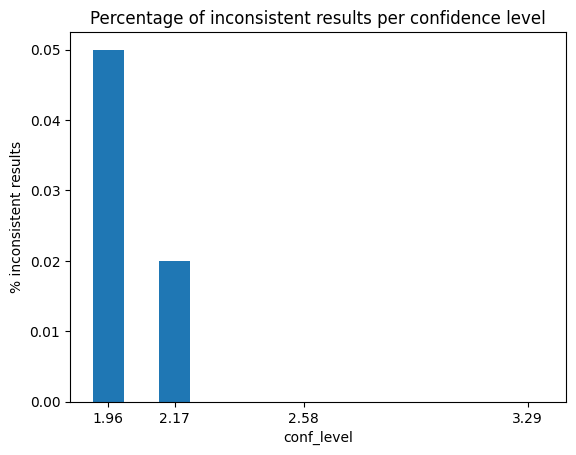

In [3]:
tot_per_conf = df.groupby('conf_level', as_index=False).count()

df['is_inconsistent'] = (df['rel_error'] > df['margin_highest'])
df['exceedance'] = np.where(df['rel_error'] > df['margin_highest'],
                            (df['rel_error'] / df['margin_highest'] - 1) * 100,
                            np.nan)

inc_plot = df.groupby('conf_level', as_index=False).agg(
    inc_count = ('is_inconsistent', 'sum'),
    avg_perc_exceedance = ('exceedance', 'mean')
)

inc_plot['total'] = inc_plot['conf_level'].map(tot_per_conf.set_index('conf_level')['rel_error'])
inc_plot['perc_inc'] = inc_plot['inc_count'] / inc_plot['total'] * 100

inc_plot['avg_perc_exceedance'] = inc_plot['avg_perc_exceedance'].round(0)
inc_plot['perc_inc'] = inc_plot['perc_inc'].round(2)
print(inc_plot)

###### PLOT INCONSISTENT RESULTS PER CONF_LEVEL #######
plt.bar(inc_plot['conf_level'], inc_plot['perc_inc'], width=0.1)
plt.title('Percentage of inconsistent results per confidence level')
plt.xlabel('conf_level')
plt.ylabel("% inconsistent results")
plt.xticks(inc_plot['conf_level'])
plt.show()


Not many inconsistencies - that's good!

# Aggregate & Normalize

##### Aggregate series of repetitive runs for the same board_state and parameters

In [6]:
avg_res = df.groupby(['board_state_100chars_code', 'conf_level', 'margin_est', 'margin_highest'], as_index=False).agg(
    rel_error = ('rel_error', 'mean'),
    time_mc = ('time_mc', 'mean'),
    max_error = ('rel_error', 'max'),
    )
print(avg_res.sample(5))


                                                                                board_state_100chars_code  conf_level  margin_est  margin_highest  rel_error  time_mc  max_error
732  0000700000077700007007370777007737075700373707577737777757743707275774770727577400077777740070007077        3.29         1.0            0.08   0.000000   3.6834    0.00000
538  0000077270077770727007227077700777700000700070000007777701000733370700077777000000007777770007755555        2.17         1.0            0.08   0.000000   0.1172    0.00000
360  0000070070000007770000007757070000075700700007577777777757742273775774777377777407737722740077777777        3.29         1.0            0.24   0.012479   0.4046    0.07752
527  0000077270077770727007227077700777700000700070000007777701000733370700077777000000007777770007755555        1.96         1.0            0.16   0.000000   0.0686    0.00000
704  0000700000077700007007370777007737075700373707577737777757743707275774770727577400077777740070007077        1.

##### Normalize average error to 0.5%

Normalization is necessary in order to aggregate and compare data from different board states 

0.5% is an acceptable level of average error, that I will use as a reference point and compare rest of results to it.

error_normalized is expressed as % of 0.5% error


In [7]:
avg_res['error_normalized'] = avg_res['rel_error'] / 0.005 * 100


##### Normalize time
For each board state find minimum time_mc for which ['error_normalized'] < 100. This will be reference time

time_normalized is expressed as % of time needed to achieve reference point error (0.5%)

For example, time_normalized = 200 means it takes twice as long as reference, so we should expect lower error

Additionally, attach a new column with information about time_adv for each board state

In [8]:
avg_res_per_game = avg_res.loc[(avg_res['error_normalized'] < 100)]

avg_res_per_game = avg_res_per_game.groupby(['board_state_100chars_code'], as_index=False).agg(
    time_at_100_error = ('time_mc', 'min'),
    )

# Map 'time_at_100_error' and 'time_adv' to original avg_res dataframe
avg_res['time_at_100_error'] = avg_res['board_state_100chars_code'].map(avg_res_per_game.set_index('board_state_100chars_code')['time_at_100_error'])
avg_res['time_adv'] = avg_res['board_state_100chars_code'].map(adv_times_df.set_index('board_state_100chars_code')['time_adv'])

# Normalize 'time_mc' as percentage of 'time_at_100_error'
avg_res['time_normalized'] = avg_res['time_mc'] / avg_res['time_at_100_error'] * 100

# Normalize advanced time as percentage of 'time_at_100_error'
avg_res['time_adv'] = avg_res['board_state_100chars_code'].map(adv_times_df.set_index('board_state_100chars_code')['time_adv'])
avg_res['time_adv_normalized'] = avg_res['time_adv'] / avg_res['time_at_100_error'] * 100

print(avg_res.sample(20))

                                                                                 board_state_100chars_code  conf_level  margin_est  margin_highest  rel_error  time_mc  max_error  error_normalized  time_at_100_error  time_adv  time_normalized  time_adv_normalized
177   0000070000777777700075555577007777777070700070070777777777773733374444377777777737000722707700777770        2.17         1.0            0.22   0.002667   0.1567    0.13333            53.332             0.1167      0.07       134.275921            59.982862
1003  0000700700177700707017570707000757070077775777707207577277720757727077777777770000007777770000744447        3.29         1.0            0.14   0.000000   0.5173    0.00000             0.000             0.0470      0.06      1100.638298           127.659574
1383  7270000000727007000077707000000007777777007755555707077777777077700000007370000700737707000073770000        1.96         1.0            0.24   0.024349   0.0918    0.08327           486.988             0.4

# Problems encountered

By looking at the above df, I realized 2 big problems.
1. There's many board states, for which time_adv is significantly lower then time_mc. This happened because, out of impatience, in order to get lots of results fast, I launched the calculations mostly with board states containing low amount of free fields. The catch is, in those cases advanced method turns out to be faster than the probabilistic one, so it makes no sense to study the probabilistic performance, while better and faster method is available...
2. For those cases, the possible relative errors are also quite low, so even with margin_highest of 0.30 we are not getting higher errors than just a couple %. It obiously makes the average score unfairly biased towards using high margin_highest parameters, because od lower calculation time which can't really affect accuracy there. 

# Summary and conclusions

1. Run another study to determine when mc/adv methods should be used.
2. From loop 2 results, remove those obtained from board states, which are not supposed to be calculated with mc method. Only use the remaining ones for further assessment.
